# SWB Prospect Theory Modeling


Created: 06/20/2023 by Alie Fink

In [1]:
import numpy as np
import random
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.optimize import minimize # minimize function is used for parameter recovery 
import seaborn as sns 
import tqdm
from scipy.stats import pearsonr
import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/swb_behav_models/scripts/')
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/scripts/python_pipeline/')
import SWB_modeling_utils, SWB_behav_utils

## Find Optim Params

In [4]:
swb_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/'
subj_list = pd.read_excel(f'{swb_dir}SWB_subjects.xlsx', sheet_name='pt_info', usecols=[0])
subj_ids = list(subj_list.PatientID)

ValueError: Worksheet named 'pt_info' not found

In [18]:
subj_ids

['DA4',
 'DA5',
 'DA06',
 'DA8',
 'DA9',
 'DA10',
 'DA11',
 'DA023',
 'MS002',
 'MS003',
 'MS004',
 'MS016',
 'MS017',
 'MS019',
 'MS022',
 'MS024',
 'MS025',
 'MS026',
 'MS027',
 'MS028',
 'MS029',
 'MS030']

### Model 1: Base PT Model
- free params: risk aversion, loss aversion, temp
- bounds = (0.1,3),(0.1,5),(0.1,20)
- beta distrubution assumptions = [1,9],[2,4],[1,8]

distribution assumptions estimated from Charpentier et al 2016 DATA_for_JASP_Anxiety.xlsx


In [19]:
#subjects = pd.read_excel('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/SWB_subjects.xlsx', sheet_name=0,usecols='A')
behav_path = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

In [33]:
risk_inits = SWB_modeling_utils.param_init(n_values=1, n_iter=5, upper_bound=3, lower_bound=0.001, method='beta',beta_shape=[1,9])
loss_inits = SWB_modeling_utils.param_init(n_values=1, n_iter=5, upper_bound=6, lower_bound=0.001, method='beta',beta_shape=[2,4])
temp_inits = SWB_modeling_utils.param_init(n_values=1, n_iter=5, upper_bound=10, lower_bound=0.01, method='beta',beta_shape=[1,8])

In [34]:
swb_base_pt_dict = {}
bounds=(0.001,3),(0.001,6),(0.01,10)

for subj_id in subj_ids:
    df = pd.read_csv(f'{behav_path}{subj_id}_task_data')

    risk_est, loss_est, temp_est, bic_est, optim_inits = SWB_modeling_utils.run_base_pt(df,risk_inits,loss_inits,temp_inits,bounds=bounds)
    if risk_est == 0:
        print(subj_id)
    swb_base_pt_dict[subj_id] = {'risk_estimation':risk_est,
                                'loss_estimation':loss_est,
                                'temp_estimation':temp_est,
                                'bic_estimation':bic_est,
                                'optim_inits':optim_inits}


In [36]:
swb_base_pt_dict

{'DA4': {'risk_estimation': 2.0770136474518077,
  'loss_estimation': 0.001,
  'temp_estimation': 7.876018327103072,
  'bic_estimation': 251.15032749075067,
  'optim_inits': (0.6292432165597787, 3.2507801821399847, 0.4684918598929692)},
 'DA5': {'risk_estimation': 1.6666082895523708,
  'loss_estimation': 0.001,
  'temp_estimation': 3.370104775926827,
  'bic_estimation': 238.34807449027699,
  'optim_inits': (0.3185861448636937, 1.3540009987760058, 0.4684918598929692)},
 'DA06': {'risk_estimation': 1.48314577782163,
  'loss_estimation': 0.2612680505623983,
  'temp_estimation': 3.924274704424225,
  'bic_estimation': 209.3402645393229,
  'optim_inits': (0.3185861448636937, 3.2507801821399847, 0.5910793871651276)},
 'DA8': {'risk_estimation': 1.2121208672879251,
  'loss_estimation': 5.111117819789441,
  'temp_estimation': 2.6255571842699377,
  'bic_estimation': 125.98468083971123,
  'optim_inits': (0.6292432165597787, 1.86738463034201, 0.07670835458471026)},
 'DA9': {'risk_estimation': 1.484

In [120]:
subj_ids

['DA8',
 'DA9',
 'DA10',
 'DA11',
 'DA023',
 'MS002',
 'MS003',
 'MS016',
 'MS017',
 'MS019',
 'MS022',
 'MS025',
 'MS026',
 'MS027',
 'MS029',
 'MS030']

In [37]:
risk_list = []
loss_list = []
temp_list = []

for subj_id in subj_ids:
    risk_list.append(swb_base_pt_dict[subj_id]['risk_estimation'])
    loss_list.append(swb_base_pt_dict[subj_id]['loss_estimation'])
    temp_list.append(swb_base_pt_dict[subj_id]['temp_estimation'])


In [38]:
risk_list

[2.0770136474518077,
 1.6666082895523708,
 1.48314577782163,
 1.2121208672879251,
 1.4843856178956314,
 0.7817681632645985,
 1.1996246782257252,
 0.9946075812467525,
 0.8182639237932114,
 0.7331448880491347,
 0.7110228915436618,
 0.6237596120789822,
 1.3259760108564742,
 1.1406442015601632,
 1.9214479251475618,
 0.6320686759435609,
 0.852420712837914,
 1.4422938148303437,
 0.6419475160465806,
 1.7743297616873506,
 0.001,
 0.7328211520270005]

In [39]:
loss_list ## try more initializations when running on minerva 

[0.001,
 0.001,
 0.2612680505623983,
 5.111117819789441,
 0.8368549587963489,
 1.7271896148559844,
 0.22625572543734593,
 1.8643806503756932,
 3.1790613079193686,
 0.001,
 6.0,
 0.9697373736974881,
 0.9891777731679184,
 0.001,
 0.102132062864625,
 6.0,
 6.0,
 1.7282977902960939,
 0.6486162006582963,
 0.5661860108881788,
 0.603489127599535,
 1.1442582593350652]

In [43]:
temp_list

[7.876018327103072,
 3.370104775926827,
 3.924274704424225,
 2.6255571842699377,
 3.2610526488097404,
 3.0586028397028677,
 1.5277511073342827,
 2.0890408223345243,
 1.5280155497754393,
 5.11869009443741,
 0.3169791967259489,
 6.760217755228342,
 6.336838086300928,
 6.780384595156907,
 3.4937442622988244,
 1.3076023966389805,
 1.1038024656932455,
 1.9994303668923679,
 5.595922963084526,
 9.505228486635469,
 0.7233851866852066,
 5.3573422031827445]

In [40]:
pt_params_df = pd.DataFrame(list(zip(subj_ids,risk_list,loss_list,temp_list)),
                            columns=['PatientID','Risk_Aversion','Loss_Aversion','Inverse_Temperature']

)

In [41]:
date = '06262023'
pt_params_df.to_csv(f'/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/swb_behav_models/data/swb_base_pt_params_{date}.csv',index=False)

In [42]:
import pickle 
save_path = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/swb_behav_models/data/'

# create a binary pickle file 
f = open(f'{save_path}/swb_pt_optim_{date}.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(swb_base_pt_dict,f)
# # close file
f.close()

## Run pt models with optim params

In [48]:
swb_base_pt_dfs = {}
bounds=(0.001,3),(0.001,6),(0.01,10)

for subj_id in subj_ids:
    df = pd.read_csv(f'{behav_path}{subj_id}_task_data')
    optim_risk = swb_base_pt_dict[subj_id]['risk_estimation']
    optim_loss = swb_base_pt_dict[subj_id]['loss_estimation']
    optim_temp = swb_base_pt_dict[subj_id]['temp_estimation']
    params = (optim_risk,optim_loss,optim_temp)

    pt_df = SWB_modeling_utils.fit_base_pt(params, df)
    swb_base_pt_dfs[subj_id] = pt_df

In [49]:
swb_base_pt_dfs

{'DA4':       tr  choice  choice_prob choice_pred  choice_pred_prob  util_gamble  \
 0      0  gamble     0.811678      gamble          0.811678     0.267524   
 1      1  gamble     0.498928        safe          0.501072    -0.000782   
 2      2  gamble     0.796094      gamble          0.796094     0.172938   
 3      3  gamble     0.497876        safe          0.502124    -0.001161   
 4      4  gamble     0.497921        safe          0.502079    -0.001293   
 ..   ...     ...          ...         ...               ...          ...   
 148  148  gamble     0.499277        safe          0.500723    -0.000449   
 149  149  gamble     0.499891        safe          0.500109    -0.000091   
 150  150  gamble     0.506544      gamble          0.506544     0.003323   
 151  151  gamble     0.947548      gamble          0.947548     0.449471   
 152  152  gamble     0.493969        safe          0.506031    -0.003409   
 
      util_safe  weighted_high  weighted_low  p_gamble    p_safe  


In [46]:
import pickle 
save_path = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/swb_behav_models/data/'

# create a binary pickle file 
f = open(f'{save_path}/swb_pt_dfs_{date}.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(swb_base_pt_dfs,f)
# # close file
f.close()

In [50]:
pt_df

,tr,choice,choice_prob,choice_pred,choice_pred_prob,util_gamble,util_safe,weighted_high,weighted_low,p_gamble,p_safe
0,0,gamble,0.323013,safe,0.676987,0.372833,0.510953,0.372833,0.000000,0.323013,0.676987
1,1,gamble,0.499058,safe,0.500942,-0.000704,0.000000,0.612815,-0.613518,0.499058,0.500942
2,2,safe,0.669531,safe,0.669531,-0.605324,-0.473530,0.000000,-0.605324,0.330469,0.669531
3,3,gamble,0.499471,safe,0.500529,-0.000395,0.000000,0.343870,-0.344265,0.499471,0.500529
4,4,gamble,0.525044,gamble,0.525044,-0.669816,-0.688530,0.000000,-0.669816,0.525044,0.474956
...,...,...,...,...,...,...,...,...,...,...,...
145,145,gamble,0.710376,gamble,0.710376,0.769200,0.601726,0.769200,0.000000,0.710376,0.289624
146,146,gamble,0.459939,safe,0.540061,-0.503506,-0.473530,0.000000,-0.503506,0.459939,0.540061
147,147,gamble,0.607895,gamble,0.607895,-0.705107,-0.786953,0.000000,-0.705107,0.607895,0.392105
148,148,gamble,0.294886,safe,0.705114,-0.747387,-0.584662,0.000000,-0.747387,0.294886,0.705114


## Save new task data with PT info

In [80]:
behav_path = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

for subj_id in subj_ids:
    #load task_data 
    task = pd.read_csv(f'{behav_path}{subj_id}_task_data')
    pt_df = swb_base_pt_dfs[subj_id]
    task['util_g'] = pt_df['util_gamble']
    task['util_s'] = pt_df['util_safe']
    task['weighted_high'] = pt_df['weighted_high']
    task['weighted_low'] = pt_df['weighted_low']
    task['p_g'] = pt_df['p_gamble']
    task['p_s'] = pt_df['p_safe']
    task = SWB_modeling_utils.get_pt_utils(task)
    
    task.to_csv(f'{behav_path}{subj_id}_pt_task_data')

In [69]:
task

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,weighted_low,p_g,p_s,util_rpe,util_tcpe,util_dcpe,util_tregret,util_dregret,util_trelief,util_drelief
0,1,71.0,gain,338.974325,338.990023,341.769751,343.785613,2.779728,0.4,0.00,...,0.000000,0.323013,0.676987,0.000000,0.000000,-0.138121,0.000000,0.000000,0.372833,-0.138121
1,2,45.0,mix,348.529057,348.538356,350.748341,352.764467,2.209985,0.0,-1.10,...,-0.613518,0.499058,0.500942,-0.612815,-1.226333,-0.613518,-1.226333,-0.613518,0.000000,0.000000
2,3,118.0,loss,357.472201,357.472927,361.825850,361.833741,4.352923,-0.3,-1.08,...,-0.605324,0.330469,0.669531,0.000000,-0.473530,-0.473530,-0.473530,-0.473530,0.000000,0.000000
3,4,38.0,mix,376.285557,376.286286,379.382670,381.399306,3.096384,0.0,-0.50,...,-0.344265,0.499471,0.500529,0.344265,0.000000,0.343870,0.000000,0.000000,0.688135,0.343870
4,5,135.0,loss,386.077311,386.087170,390.027117,392.043705,3.939948,-0.5,-1.24,...,-0.669816,0.525044,0.474956,0.669816,0.000000,0.688530,0.000000,0.000000,0.669816,0.688530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,88.0,gain,2034.227729,2034.228451,2036.572647,2038.588018,2.344195,0.5,0.00,...,0.000000,0.710376,0.289624,0.000000,0.000000,0.167474,0.000000,0.000000,0.769200,0.167474
146,147,116.0,loss,2043.926806,2043.932572,2047.849714,2049.865416,3.917142,-0.3,-0.84,...,-0.503506,0.459939,0.540061,0.000000,-0.503506,-0.029976,-0.503506,-0.029976,0.000000,0.000000
147,148,144.0,loss,2059.311537,2059.312296,2062.092662,2064.108756,2.780366,-0.6,-1.33,...,-0.705107,0.607895,0.392105,0.000000,-0.705107,0.081845,-0.705107,0.081845,0.000000,0.000000
148,149,128.0,loss,2069.315797,2069.316549,2073.719847,2075.736168,4.403297,-0.4,-1.44,...,-0.747387,0.294886,0.705114,0.000000,-0.747387,-0.162724,-0.747387,-0.162724,0.000000,0.000000


## Update model data for GLM inputs

In [81]:
subjects = pd.read_excel('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/SWB_subjects.xlsx', sheet_name=0,usecols='A')

In [82]:
subjects

,PatientID
0,DA8
1,DA9
2,DA10
3,DA11
4,DA023
5,MS002
6,MS003
7,MS016
8,MS017
9,MS019


In [83]:
behav_path = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

model_data_info = {} 

model_data = pd.DataFrame()


for subj_id in subjects.PatientID:
    #load task_data 
    task = pd.read_csv(f'{behav_path}{subj_id}_pt_task_data') #make sure this is the correct task df
    rate = pd.read_csv(f'{behav_path}{subj_id}_rate_data')
    model_dict = SWB_modeling_utils.get_model_data_pt(subj_id,task,rate)
    model_data_info[subj_id] = model_dict #in case dictionary of dictionaries is easier to work with later
    model_data = pd.concat([model_data,pd.DataFrame(model_dict)])

In [84]:
model_data

,subj_id,round,rate,zscore_rate,cr(t-1),cr(t-2),cr(t-3),choice_ev(t-1),choice_ev(t-2),choice_ev(t-3),...,util_tregret(t-3),util_dregret(t-1),util_dregret(t-2),util_dregret(t-3),util_trelief(t-1),util_trelief(t-2),util_trelief(t-3),util_drelief(t-1),util_drelief(t-2),util_drelief(t-3)
2,DA8,4,74.0,-1.156527,0.0,0.0,0.0,0.00,0.03,0.000,...,0.000000,-0.817361,0.000000,0.000000,0.000000,0.738802,1.949931,0.000000,0.144929,1.949931
3,DA8,7,80.0,0.054333,-0.3,-0.2,0.0,0.00,0.00,0.315,...,0.000000,-1.187746,0.000000,0.000000,0.000000,0.376491,0.285592,0.000000,0.376491,0.143437
4,DA8,10,84.0,0.861574,0.6,0.0,0.0,0.00,0.50,0.000,...,0.000000,0.000000,0.000000,0.000000,0.538384,0.500000,1.949931,0.538384,0.357844,1.949931
5,DA8,13,88.0,1.668814,-0.5,0.0,0.0,0.00,1.50,0.000,...,-0.054233,-2.206130,0.000000,-0.054233,0.000000,1.893645,0.000000,0.000000,1.355261,0.000000
6,DA8,16,89.0,1.870624,0.0,-0.5,-0.5,0.00,0.00,0.000,...,0.000000,0.000000,0.000000,0.000000,0.593873,2.243074,1.636342,0.593873,2.243074,1.636342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,MS030,139,47.0,0.261100,0.0,0.0,0.0,0.56,-0.56,0.000,...,0.000000,-0.510953,-0.037011,0.000000,0.000000,0.000000,0.770083,0.000000,0.000000,0.770083
47,MS030,142,46.0,-0.372999,0.0,0.0,0.0,-0.79,0.00,0.000,...,0.000000,-0.111441,0.000000,0.000000,0.000000,0.485821,0.236765,0.000000,0.485821,0.236765
48,MS030,145,46.0,-0.372999,0.0,0.2,0.0,-0.42,0.00,0.000,...,-0.260142,0.185024,0.000000,-0.260142,0.000000,0.307454,0.000000,0.000000,0.307454,0.000000
49,MS030,148,47.0,0.261100,0.0,0.0,0.0,-0.42,0.90,0.315,...,0.000000,-0.029976,0.000000,0.000000,0.000000,0.769200,0.356388,0.000000,0.167474,0.048934


In [85]:
model_data_path = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/swb_behav_models/data/'
model_data.to_csv(f'{model_data_path}pt_model_input_data_{date}',index=False)


## Test PT models

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


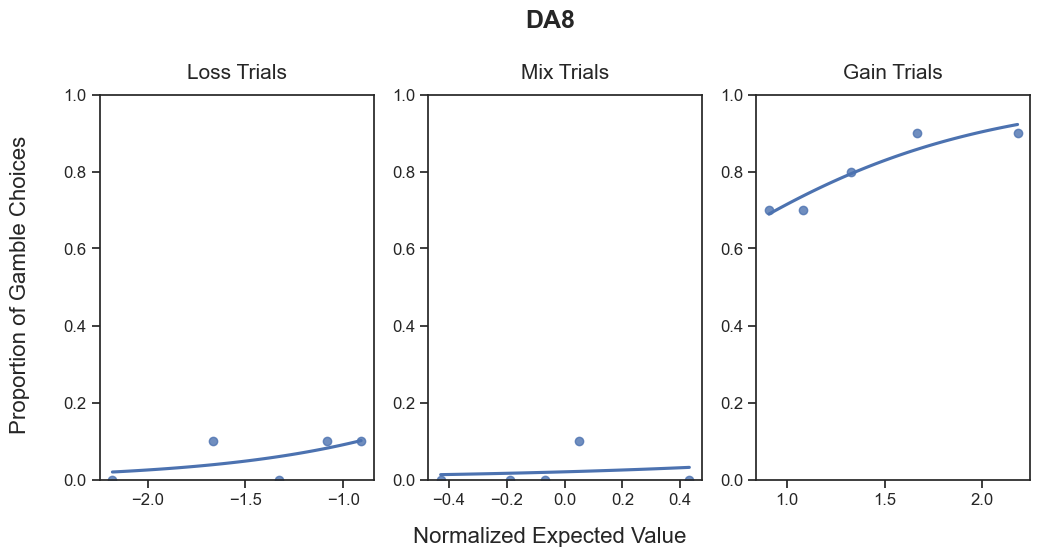

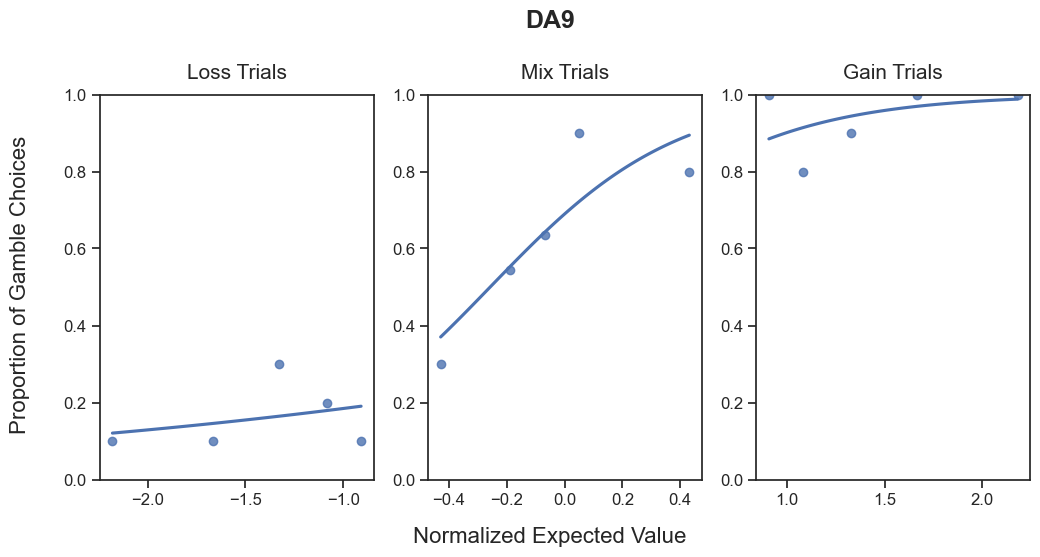

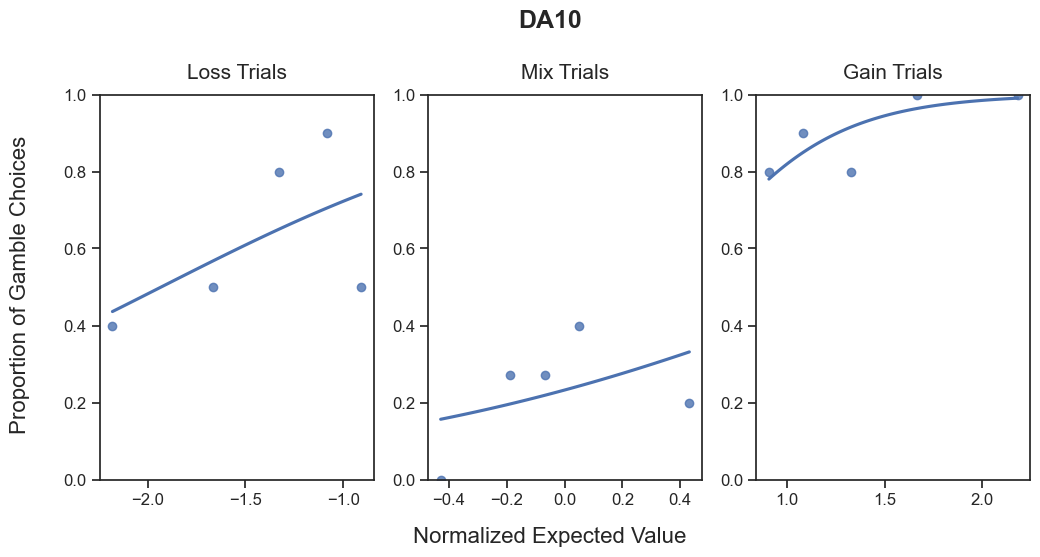

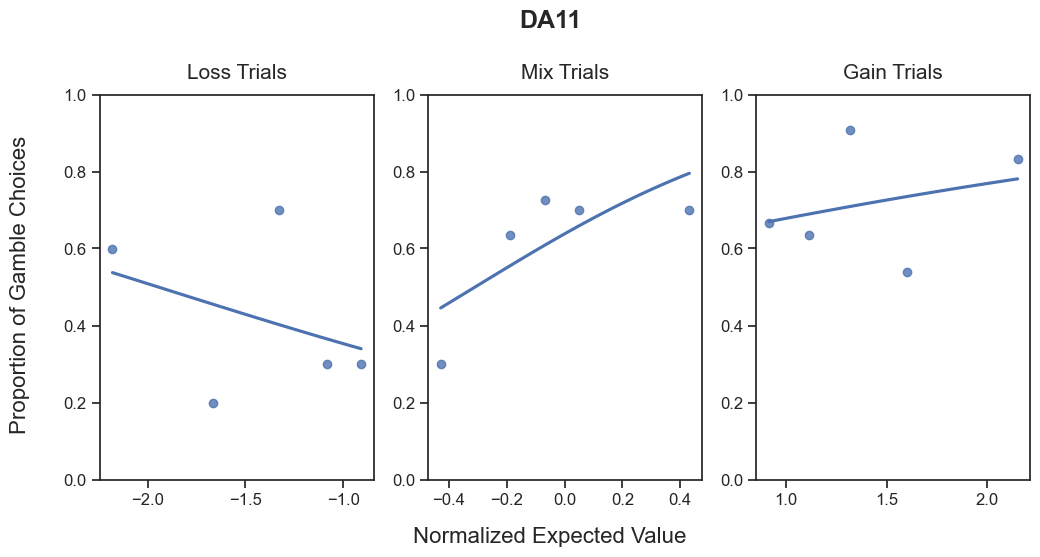

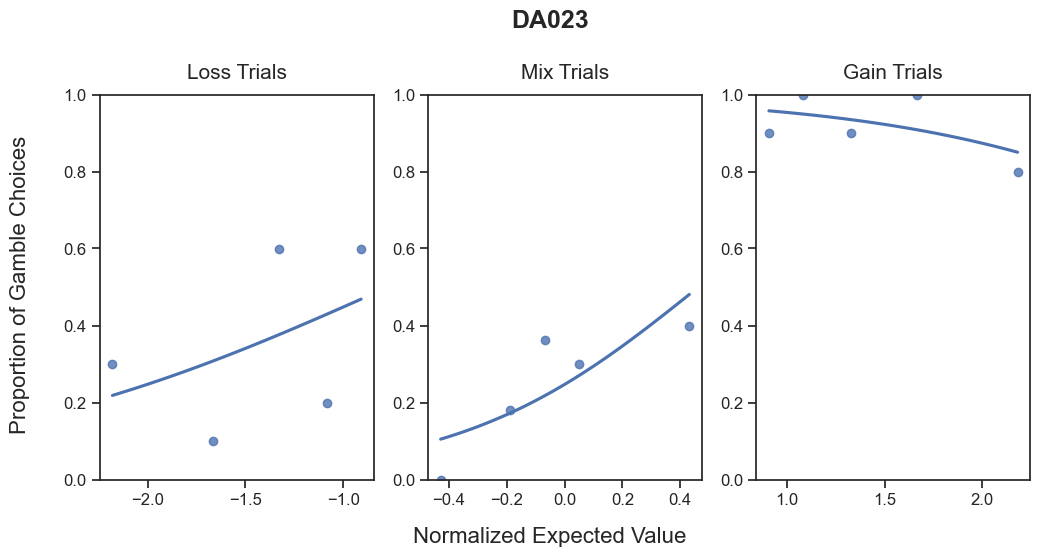

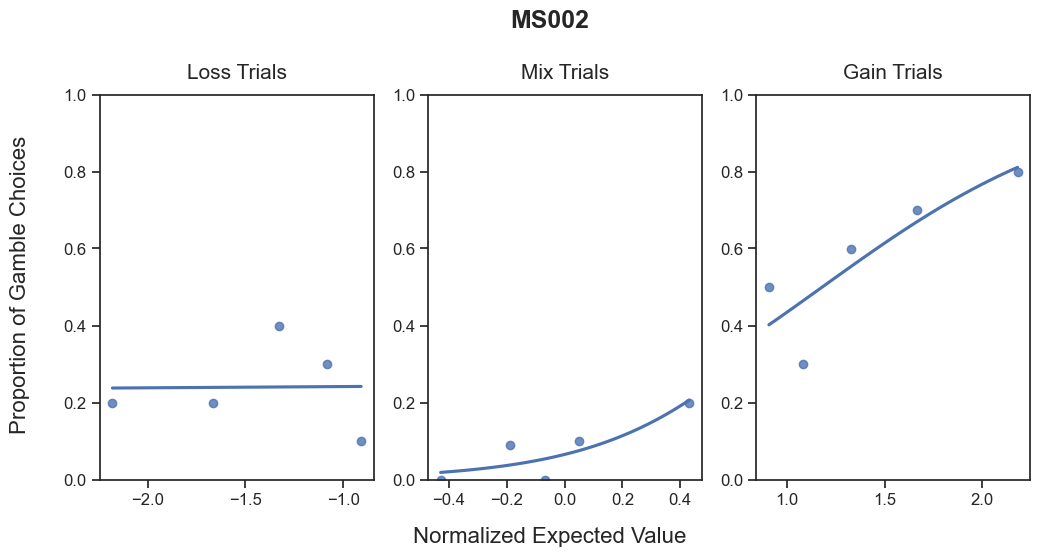

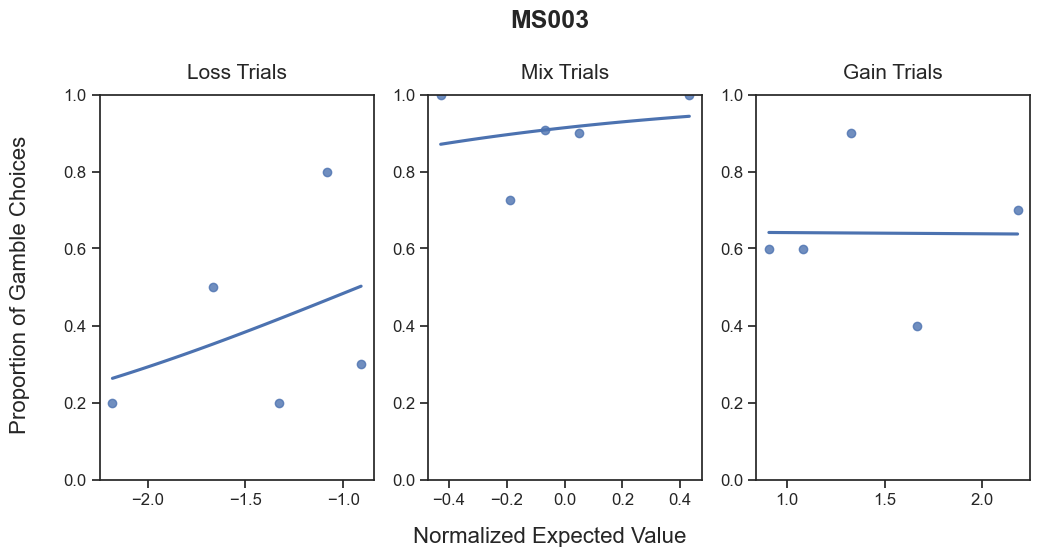

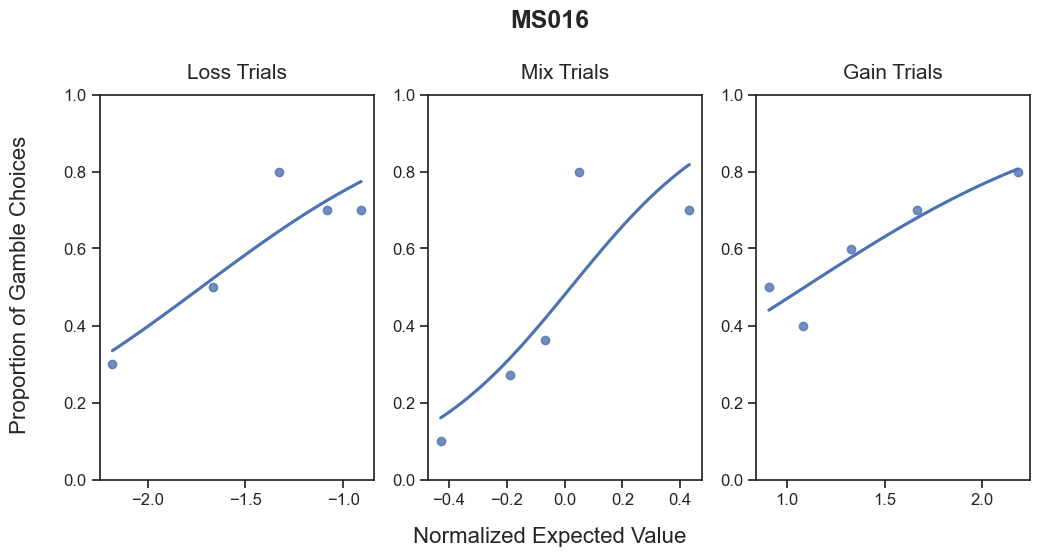

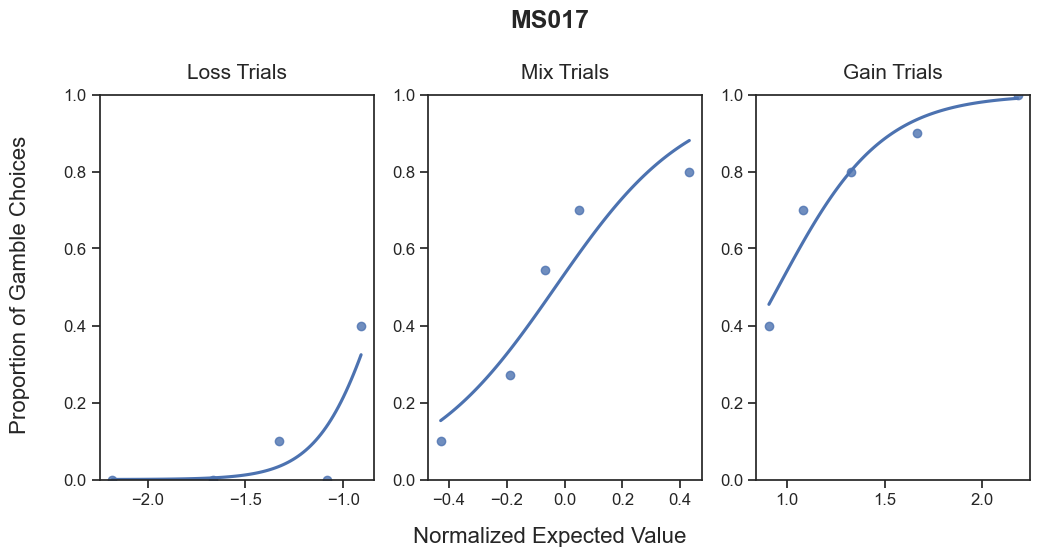

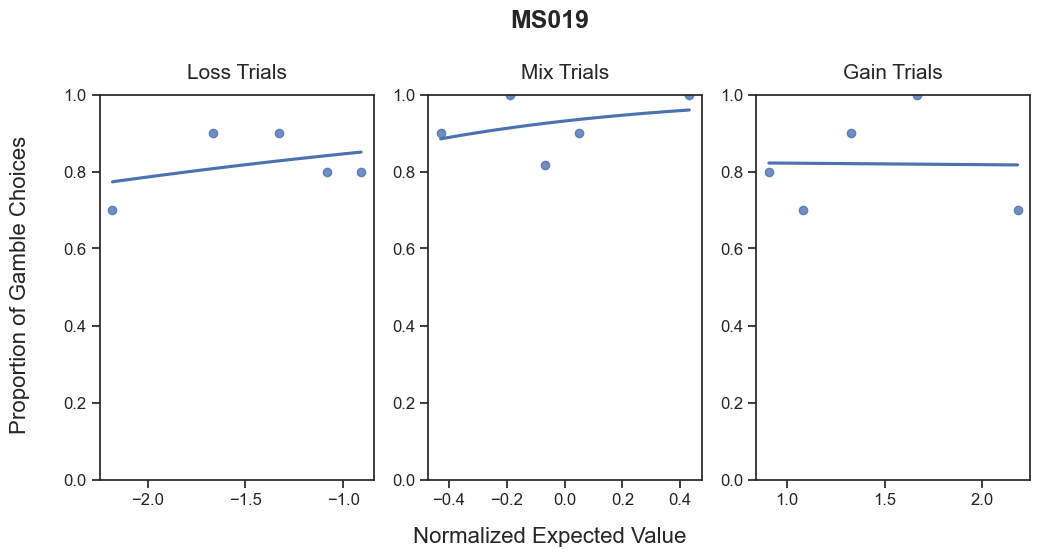

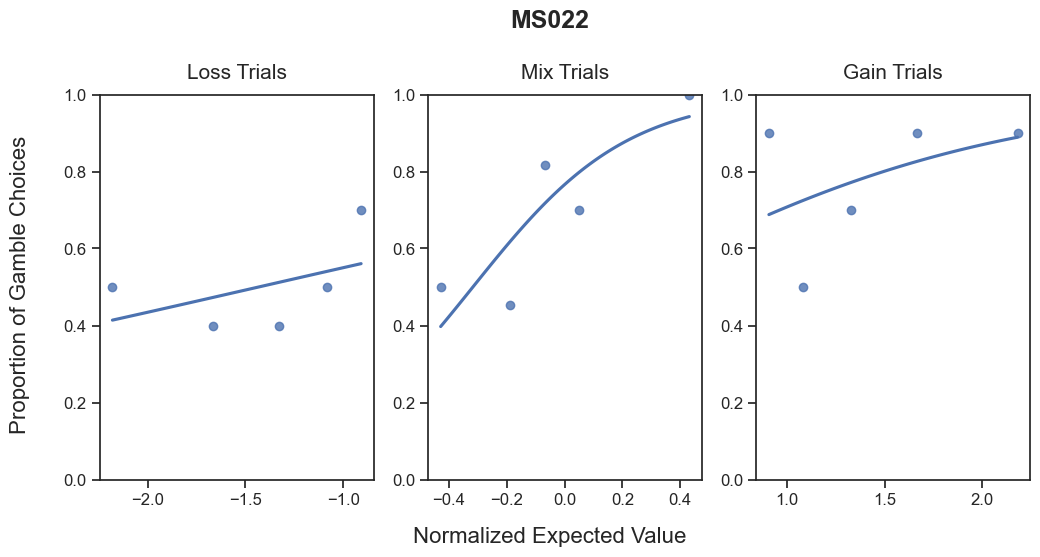

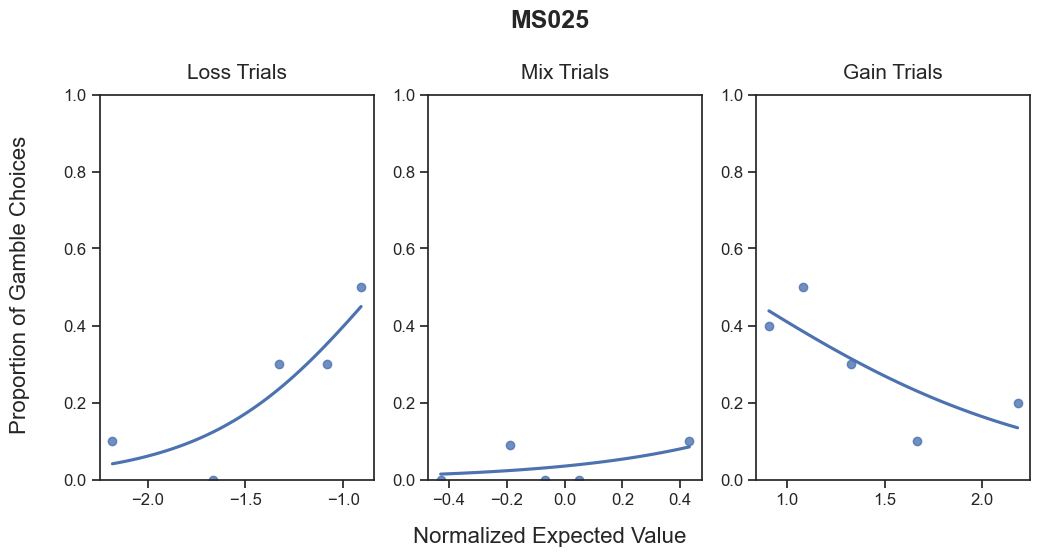

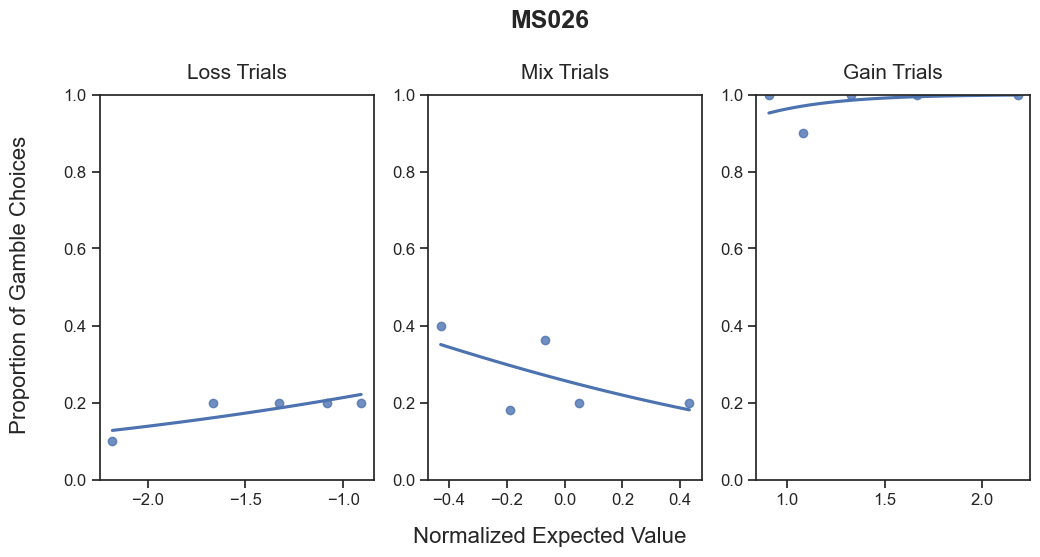

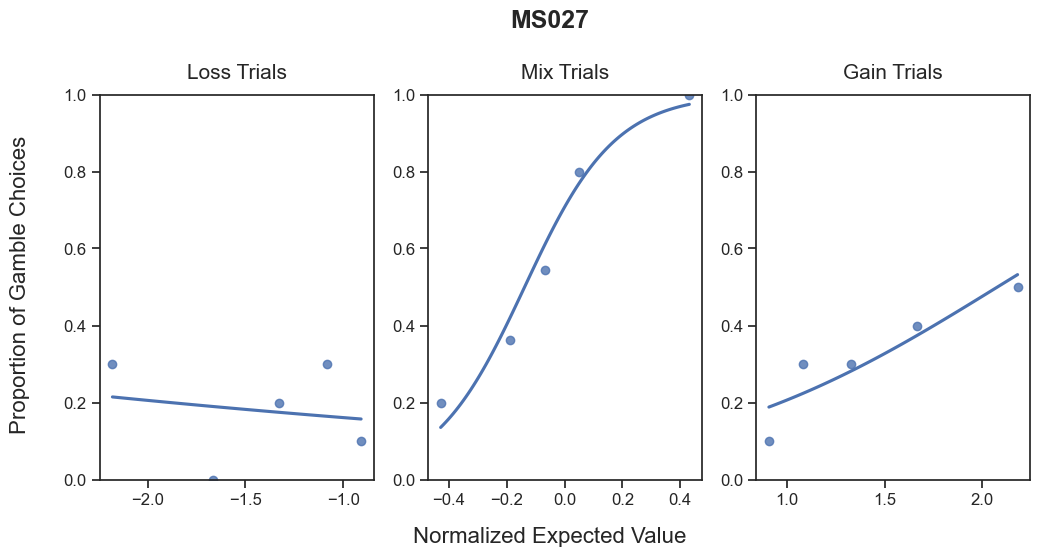

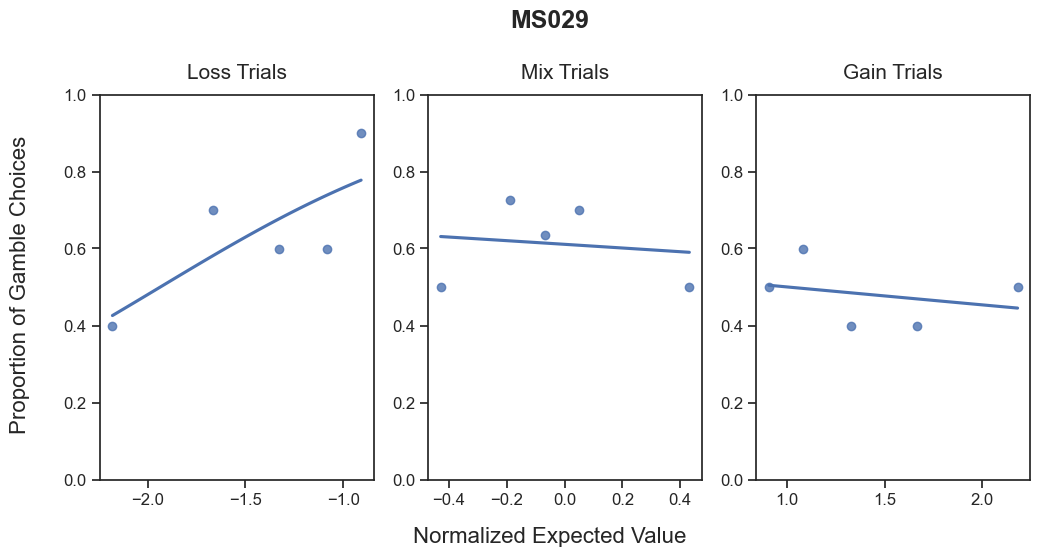

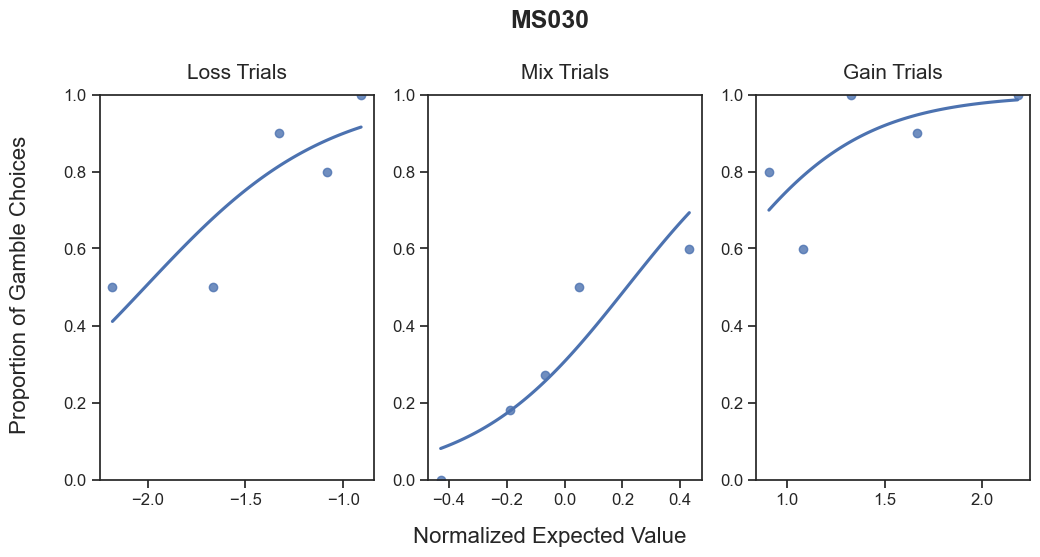

In [162]:
behav_path = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'


for subj_id in subj_ids:
    #load task_data 
    task = pd.read_csv(f'{behav_path}{subj_id}_pt_task_data') #make sure this is the correct task df with pt data
    loss, mix, gain = SWB_behav_utils.util_norm_gamble_choices(task)
    fig = SWB_behav_utils.plot_gamble_choices(subj_id,task)
    

In [ ]:
############### code from shawn bayesian model selection    "integrated BIC" 
#here, the mean and variance from a hierarchical model fit are use to generate 2000 samples of paramters, but you can still use the mean and variance from the individual fits in your data. fit.beh is just the behavioral data for all subjects. fit.objfunc is the function for outputing the negll

#https://www.nature.com/articles/s41467-020-17343-w

# Nsample     = 2000

# % info for normpdf, and flip if it is the wrong orientation
# mu          = mroot.(modelID).gauss.mu;            if size(mu,2)>size(mu,1),                 mu = mu'; end
# sigmasqrt   = sqrt(mroot.(modelID).gauss.sigma);   if size(sigmasqrt,2)>size(sigmasqrt,1),   sigmasqrt = sigmasqrt'; end

# % collect integrated nll
# iLog        = nan(numel(fit.beh),1); 

# % 1)get integrated nll by sampling nll from group gaussian
# fprintf([modelID ' - BICint: ']);
# for is = 1:numel(fit.beh)
   
#    subnll = nan(1,Nsample);
#    Gsamples    = normrnd(repmat(mu,1,Nsample),repmat(sigmasqrt,1,Nsample));  % samples from gaussian distribution found during EM; draw anew for each subject

#    % for each subject, get NLL for input params from gaussian
#    for k=1:Nsample
#       subnll(k)  = fit.objfunc(fit.beh{is},Gsamples(:,k)); 
#    end
#    fprintf([ num2str(is) ',']);
#    iLog(is) = log(sum(exp(-subnll))/Nsample);
# end

# % 2) Compute BICint
# bicint  = -2*sum(iLog)   + fit.npar*log(sum(fit.ntrials)); 